# Methods for finding the scaling factor

This notebook compares different methods of finding the scaling factor to be applied to the single-dish data. uv-samples where the interometer-ed image and single-dish image overlap are compared.

In [1]:
# ipython notebook setup:
%matplotlib inline

In [2]:
import pylab as pl
pl.rcParams['image.interpolation'] = 'nearest'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (12,8)
pl.rcParams['image.cmap'] = 'viridis'
pl.rcParams['patch.edgecolor'] = 'none'
pl.rcParams['axes.prop_cycle'] = pl.cycler('color', ('#338ADD', '#9A44B6', '#A60628', '#467821', '#CF4457', '#188487', '#E24A33'))

In [3]:
import image_registration
from astropy import convolution
import numpy as np
from uvcombine.uvcombine import feather_compare
from uvcombine.scale_factor import find_effSDbeam
# from uvcombine.tests.utils import generate_test_fits
from astropy.utils.console import ProgressBar

In [4]:
# create an input image with specified parameters
# (this can later be modified - it will be good to examine the effects of
# different power laws, different types of input...)
# We're assuming a scale of 1"/pixel for this example
np.random.seed(0)
imsize = 1024
im = image_registration.tests.make_extended(imsize=imsize, powerlaw=1.5)

In [5]:
ygrid, xgrid = np.indices(im.shape, dtype='float')
rr = ((xgrid-im.shape[1]/2)**2+(ygrid-im.shape[0]/2)**2)**0.5

In [6]:
# Create a UV sampling mask.
# This removes all large-angular scale (r<8) features *in UV space* and all
# small angular scales.
# In fourier space, r=0 corresponds to the DC component
# r=1 corresponds to the full map (one period over that map)
# r=256 is the smallest angular scale, which is 2 pixels (nyquist sampling....?)
# We're assuming a pixel scale of 1" / pixel
# therefore 56" corresponds to 9m at 2mm (i.e., nearly the closest spacing possible for 7m)
# We cut off the "interferometer" at 2.5" resolution
largest_scale = 56.
smallest_scale = 2.5
image_scale = im.shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

In [7]:
# create the interferometric map by removing both large and small angular
# scales in fourier space
imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)

In [8]:
# create the single-dish map by convolving the image with a FWHM=40" kernel
# (this interpretation is much easier than the sharp-edged stuff in fourier
# space because the kernel is created in real space)
lowresfwhm = 30
singledish_im = convolution.convolve_fft(im,
                                         convolution.Gaussian2DKernel(lowresfwhm/2.35),
                                         boundary='fill', fill_value=im.mean())

In [9]:
# make some headers for HDUs
pixel_scale = 1 * u.arcsec
beamfwhm = lowresfwhm * u.arcsec
restfreq = (2 * u.mm).to(u.Hz, u.spectral())
header = {'CDELT1': -(pixel_scale).to(u.deg).value,
              'CDELT2': (pixel_scale).to(u.deg).value,
              'BMAJ': beamfwhm.to(u.deg).value,
              'BMIN': beamfwhm.to(u.deg).value,
              'BPA': 0.0,
              'CRPIX1': imsize/2.,
              'CRPIX2': imsize/2.,
              'CRVAL1': 0.0,
              'CRVAL2': 0.0,
              'CTYPE1': 'GLON-CAR',
              'CTYPE2': 'GLAT-CAR',
              'CUNIT1': 'deg',
              'CUNIT2': 'deg',
              'CRVAL3': restfreq.to(u.Hz).value,
              'CUNIT3': 'Hz',
              'CDELT3': 1e6, # 1 MHz; doesn't matter
              'CRPIX3': 1,
              'CTYPE3': 'FREQ',
              'RESTFRQ': restfreq.to(u.Hz).value,
              'BUNIT': 'MJy/sr',
             }
header = fits.Header(header)

interf_header = header.copy()
interf_fwhm = smallest_scale * u.arcsec
interf_header["BMAJ"] = interf_fwhm.to(u.deg).value
interf_header["BMIN"] = interf_fwhm.to(u.deg).value

# Choosing the Correct single-dish FWHM

Feathering two datasets together depends critically on the single-dish beam model. The SD beam acts to weight the data at different scales and an incorrect weighting at certain scales will skew the feathered image. This is particularly important in the overlap region, which we use to determine if a scaling factor needs to be applied to one of the datasets. 

Here, we check the effects of assuming the wrong single-dish FWHM when calculating the scale factor. From Chapter 3 in [Stanimirovic (1999)](https://ui.adsabs.harvard.edu/#abs/1999PhDT........21S/abstract), the ratios will have a quadratic dependence of the wavenumber when the wrong FWHM is used:
$$
\mathcal{f}_{\rm cal} \approx 1 + \frac{\Delta\theta \left( 2\theta_0 + \Delta\theta \right)}{4 {\rm ln}2} k^2,
$$
where $k$ is the angular scale, $\theta_0$ is the true beam size, and $\Delta\theta << \theta_0$ is the difference between the actual and assumed beam size. The relation should then be quadratic: $\mathcal{f}_{\rm cal} \sim M + N k^2.$ (Eqs. 3.10 \& 3.11). The correct beam size should have $\Delta\theta = 0$ and so to check for the correct beam model, we can find where the slope $N$ is closest to zero.

In the example below, the true SD beam size is 30''. To check this relation, we will try beams ranging from 18'' to 46''.

In [10]:
interferometer_hdu = fits.PrimaryHDU(im_interferometered.real, header=interf_header)
singledish_hdu = fits.PrimaryHDU(singledish_im, header=header)

# Sample a large range of FWHMs
lowresfwhms = np.arange(18, 46, 0.25) * u.arcsec

The function `find_effSDbeam` takes the samples in the overlap region of the datasets and fits a linear relation between the ratios between the high- and low-resolution data against the angular scale squared. The plot below shows the slope $N$ as a function of the assumed SD beam size.

/home/eric/Dropbox/code_development/radio_astro_tools/uvcombine/uvcombine/uvcombine.py:1312: RuntimeWarning: divide by zero encountered in divide
  fft_lo_deconvolved = fft_lo / kfft
/home/eric/Dropbox/code_development/radio_astro_tools/uvcombine/uvcombine/uvcombine.py:1312: RuntimeWarning: invalid value encountered in divide
  fft_lo_deconvolved = fft_lo / kfft


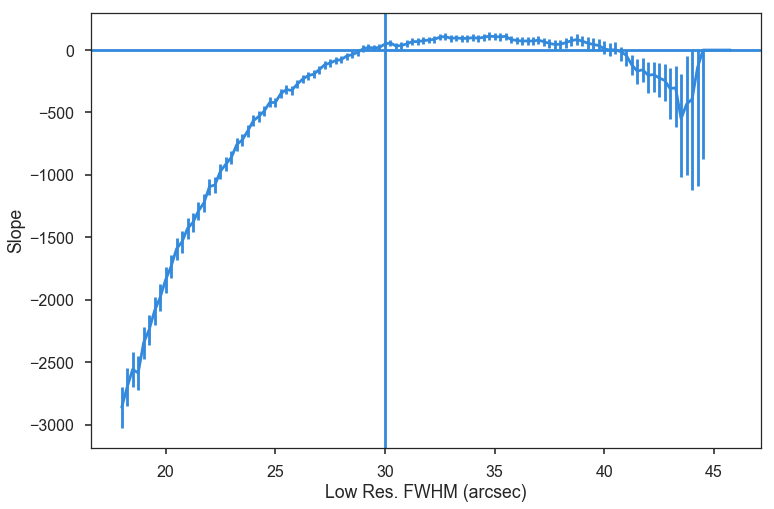

In [11]:
slopes, slopes_CI = \
    find_effSDbeam(interferometer_hdu, singledish_hdu, largest_scale * u.arcsec, lowresfwhms,
                   verbose=True)
pl.axvline(30)

The behaviour is close to quadratic, as expected, and the zero-crossing point is near to the true SD beam size. As $\Delta\theta$ gets largers, the approximation breaks down. This happens when assuming a larger beam as the curve flattens out in this regime. This suggests that overestimating the SD beam will be equally as biased for a large range.

The actual zero crossing point is slightly smaller than the beam:

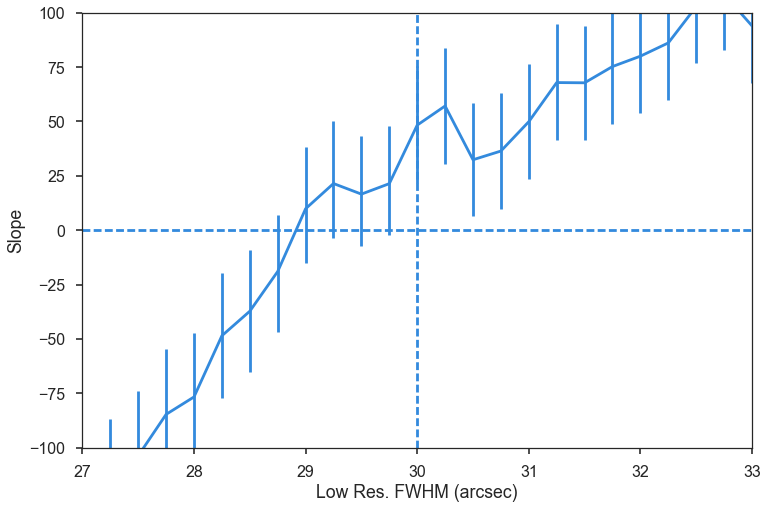

In [12]:
pl.errorbar(lowresfwhms.to(u.arcsec).value, slopes,
            yerr=[slopes - slopes_CI[0],
                  slopes_CI[1] - slopes])

pl.ylabel("Slope")
pl.xlabel("Low Res. FWHM (arcsec)")
pl.xlim([27, 33])
pl.ylim([-100, 100])
pl.axvline(30, linestyle='--', zorder=-1)
pl.axhline(0, linestyle='--', zorder=-1)

We can get a better estimate of the root by fitting a spline to the curve.

In [13]:
from scipy import interpolate

yToFind = 0
yreduced = slopes - yToFind
freduced = interpolate.UnivariateSpline(lowresfwhms.value, yreduced, s=1e5)
freduced.roots()

array([ 29.05970878,  40.13257091,  44.85118811,  45.6337948 ])

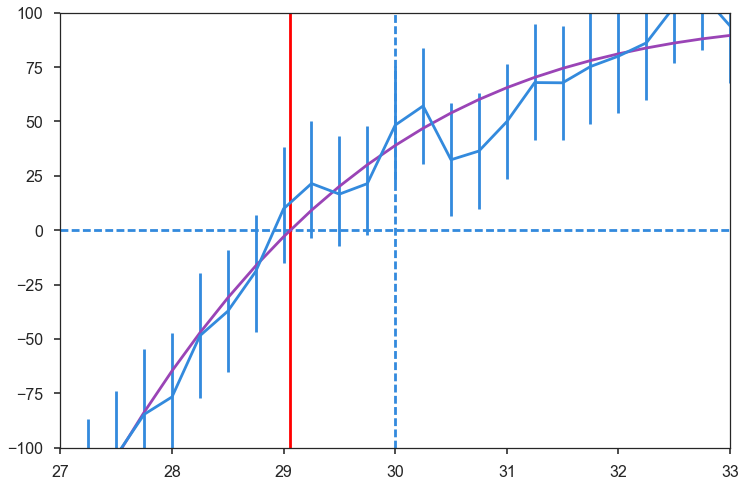

In [14]:
pl.errorbar(lowresfwhms.to(u.arcsec).value, slopes,
            yerr=[slopes - slopes_CI[0],
                  slopes_CI[1] - slopes])
pl.plot(lowresfwhms.value, freduced(lowresfwhms.value))
pl.xlim([27, 33])
pl.ylim([-100, 100])
pl.axvline(30, linestyle='--', zorder=-1)
pl.axhline(0, linestyle='--', zorder=-1)
# Closest spline root to the FWHM
pl.axvline(freduced.roots()[0], linestyle="-", color='r', zorder=-1)

The above example underestimates the true beam size by about 1", but does demonstrate that the method returns a good approximation to the true value. 

Is the beam always underestimated with this method? To test whether the method does this consistently, we will create 100 instances of power-law images with the same properties (**This might take awhile to run!**):

In [15]:
def test_effSDbeam_find(niters=100, imsize=1024, powerlaw=1.5, lowresfwhm=30 * u.arcsec, interf_las=56 * u.arcsec,
                        interf_sas=2.5 * u.arcsec, pixel_scale=1 * u.arcsec,
                        test_range=np.arange(18, 46, 0.5) * u.arcsec,
                        wavelength=2 * u.mm):
    
    found_sdbeam = np.empty((niters))
    
    for i in ProgressBar(niters):
    
        im = image_registration.tests.make_extended(imsize=imsize, powerlaw=powerlaw)
        ygrid, xgrid = np.indices(im.shape, dtype='float')
        rr = ((xgrid-im.shape[1]/2)**2+(ygrid-im.shape[0]/2)**2)**0.5
        image_scale = im.shape[0] # assume symmetric (default=256)
        ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))
    
        imfft = np.fft.fft2(im)
        imfft_interferometered = imfft * np.fft.fftshift(ring)
        im_interferometered = np.fft.ifft2(imfft_interferometered)
    
        singledish_im = convolution.convolve_fft(im,
                                                 convolution.Gaussian2DKernel(lowresfwhm.value / np.sqrt(8 * np.log(2))),
                                                 boundary='fill', fill_value=im.mean())
    
        beamfwhm = lowresfwhm
        restfreq = wavelength.to(u.Hz, u.spectral())
        header = {'CDELT1': -(pixel_scale).to(u.deg).value,
                  'CDELT2': (pixel_scale).to(u.deg).value,
                  'BMAJ': beamfwhm.to(u.deg).value,
                  'BMIN': beamfwhm.to(u.deg).value,
                  'BPA': 0.0,
                  'CRPIX1': imsize/2.,
                  'CRPIX2': imsize/2.,
                  'CRVAL1': 0.0,
                  'CRVAL2': 0.0,
                  'CTYPE1': 'GLON-CAR',
                  'CTYPE2': 'GLAT-CAR',
                  'CUNIT1': 'deg',
                  'CUNIT2': 'deg',
                  'CRVAL3': restfreq.value,
                  'CUNIT3': 'Hz',
                  'CDELT3': 1e6, # 1 MHz; doesn't matter
                  'CRPIX3': 1,
                  'CTYPE3': 'FREQ',
                  'RESTFRQ': restfreq.to(u.Hz).value,
                  'BUNIT': 'MJy/sr',
                 }
        header = fits.Header(header)

        interf_header = header.copy()
        interf_fwhm = interf_sas
        interf_header["BMAJ"] = interf_fwhm.to(u.deg).value
        interf_header["BMIN"] = interf_fwhm.to(u.deg).value
    
        interferometer_hdu = fits.PrimaryHDU(im_interferometered.real, header=interf_header)
        singledish_hdu = fits.PrimaryHDU(singledish_im, header=header)
    
        slopes, slopes_CI = \
            find_effSDbeam(interferometer_hdu, singledish_hdu, interf_las, test_range,
                           verbose=False)
    
        yToFind = 0
        yreduced = slopes - yToFind
        freduced = interpolate.UnivariateSpline(test_range.value, yreduced, s=1e5)
        closest_fwhm = freduced.roots()[np.argmin(np.abs(freduced.roots() - lowresfwhm.value))]
        
        found_sdbeam[i] = closest_fwhm
        
    return found_sdbeam * test_range.unit

In [16]:
mc_effSDbeams = test_effSDbeam_find(niters=100, test_range=np.arange(18, 46, 0.5) * u.arcsec)

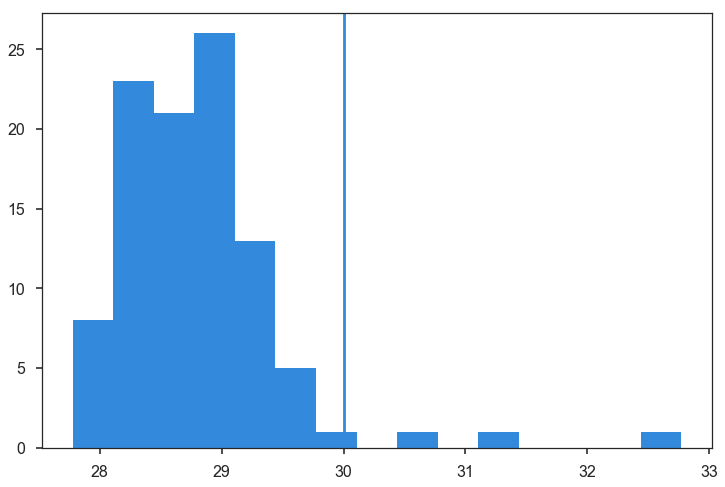

In [17]:
_ = pl.hist(mc_effSDbeams.value, bins=15)
pl.axvline(30)

Yes! The point where the slope is zero tends to be underestimated by about 1''. But this does happen to be the size of a pixel in the test data, so choosing a finer spatial grid might help.

# Determining the scale factor

With the correct beam model, the bias from choosing an incorrect beam model is removed. Now we want to calculate the overall scale factor between the datasets.

With a single plane, and limited uv-overlap, the number of samples to derive the scale factor is quite limited. If instead we have a spectral-line data cube, the samples may be combined to examine their distribution. This assumes that the noise is roughly constant in the different channels. If the data has a spectrally varying noise, a subset of the channels should be chosen.

With simulated data, what does the distribution of the ratios in the overlap region look like?

In [15]:
nplanes = 100
ratios = []
highres_pts = []
lowres_pts = []
wavelength = 2 * u.mm

for _ in ProgressBar(nplanes):
        im = image_registration.tests.make_extended(imsize=imsize, powerlaw=1.5)
        # Let's add a bit of noise
        im += np.random.normal(0, 0.8, size=im.shape)
        ygrid, xgrid = np.indices(im.shape, dtype='float')
        rr = ((xgrid-im.shape[1]/2)**2+(ygrid-im.shape[0]/2)**2)**0.5
        image_scale = im.shape[0] # assume symmetric (default=256)
        ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))
    
        imfft = np.fft.fft2(im)
        imfft_interferometered = imfft * np.fft.fftshift(ring)
        im_interferometered = np.fft.ifft2(imfft_interferometered)
    
        singledish_im = convolution.convolve_fft(im,
                                                 convolution.Gaussian2DKernel(lowresfwhm / np.sqrt(8 * np.log(2))),
                                                 boundary='fill', fill_value=im.mean())
    
        beamfwhm = lowresfwhm * u.arcsec
        restfreq = wavelength.to(u.Hz, u.spectral())
        header = {'CDELT1': -(pixel_scale).to(u.deg).value,
                  'CDELT2': (pixel_scale).to(u.deg).value,
                  'BMAJ': beamfwhm.to(u.deg).value,
                  'BMIN': beamfwhm.to(u.deg).value,
                  'BPA': 0.0,
                  'CRPIX1': imsize/2.,
                  'CRPIX2': imsize/2.,
                  'CRVAL1': 0.0,
                  'CRVAL2': 0.0,
                  'CTYPE1': 'GLON-CAR',
                  'CTYPE2': 'GLAT-CAR',
                  'CUNIT1': 'deg',
                  'CUNIT2': 'deg',
                  'CRVAL3': restfreq.value,
                  'CUNIT3': 'Hz',
                  'CDELT3': 1e6, # 1 MHz; doesn't matter
                  'CRPIX3': 1,
                  'CTYPE3': 'FREQ',
                  'RESTFRQ': restfreq.to(u.Hz).value,
                  'BUNIT': 'MJy/sr',
                 }
        header = fits.Header(header)

        interf_header = header.copy()
        interf_fwhm = smallest_scale * u.arcsec
        interf_header["BMAJ"] = interf_fwhm.to(u.deg).value
        interf_header["BMIN"] = interf_fwhm.to(u.deg).value
    
        interferometer_hdu = fits.PrimaryHDU(im_interferometered.real, header=interf_header)
        singledish_hdu = fits.PrimaryHDU(singledish_im, header=header)
        
        plane_samples = feather_compare(interferometer_hdu, singledish_hdu, SAS=lowresfwhm * u.arcsec,
                                        LAS=largest_scale * u.arcsec, lowresfwhm=lowresfwhm * u.arcsec,
                                        return_samples=True, doplot=False)
        ratios.append(plane_samples[1])
        highres_pts.append(plane_samples[2])
        lowres_pts.append(plane_samples[3])
        
ratios = np.hstack(ratios)
highres_pts = np.hstack(highres_pts)
lowres_pts = np.hstack(lowres_pts)

In [16]:
# There's some sort of numerical effect going on in the interferometer image. Remove the low outliers at the
# float precision level
good_pts = np.where(np.log(highres_pts) > -20)

It's helpful to examine the distribution of the high-to-low ratios in log space. As we'll see below, noise will cause outliers at both small and large values.

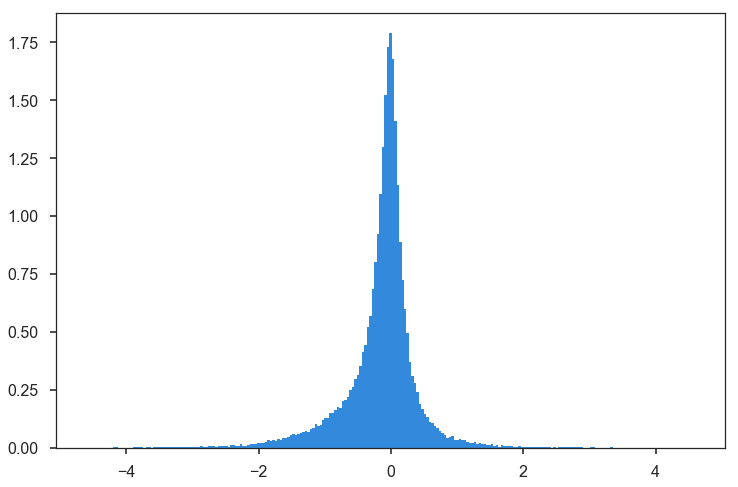

In [17]:
from astropy.visualization import hist
_ = hist(np.log(ratios[good_pts]), bins='scott', normed=True)

The ratios have strong tails in both direction. In log-space, the low-end tail is more prominent than the upper because of the image is defined as a power-law with an index $<2$. The following analysis treats these tails as symmetric, which is appropriate for images dominated by a log-normal distribution. This tends to be a better approximation for observational data.

Why do we get these tails? The histograms of the intensity values from the low- and high-resolution data are (not quite) log-normals. 

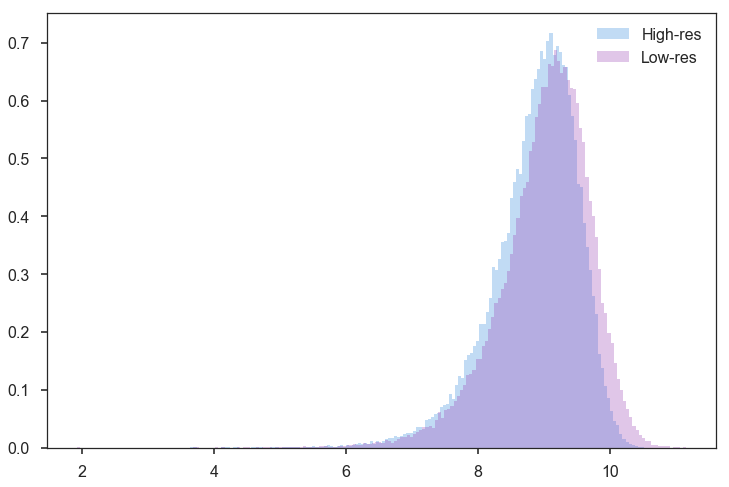

In [19]:
_ = hist(np.log(highres_pts[good_pts]), bins='scott', normed=True, alpha=0.3, label="High-res")
_ = hist(np.log(lowres_pts), bins='scott', normed=True, alpha=0.3, label="Low-res")
p.legend()

It would be more appropriate to treat each distribution as a power-law log-normal distribution. For the purposes of showing how to get the scale factor, assume these are log-normal variates (because it's a lot easier).

The ratio of two normal random variates results in a Cauchy distribution. So the ratio of two log-normally distributed variables is a Cauchy distribution in log-space. Thus to find the scaling factor, the log of the ratio is fit to a Cauchy distribution. Its median is then an estimate of the scaling factor.

In [20]:
import scipy.stats
cauchy_fit = stats.cauchy.fit(np.log(ratios[good_pts]))
print(cauchy_fit)
print(np.exp(np.array(cauchy_fit)))

(-0.048407925115173611, 0.1812299181628054)
[ 0.95274506  1.19869075]


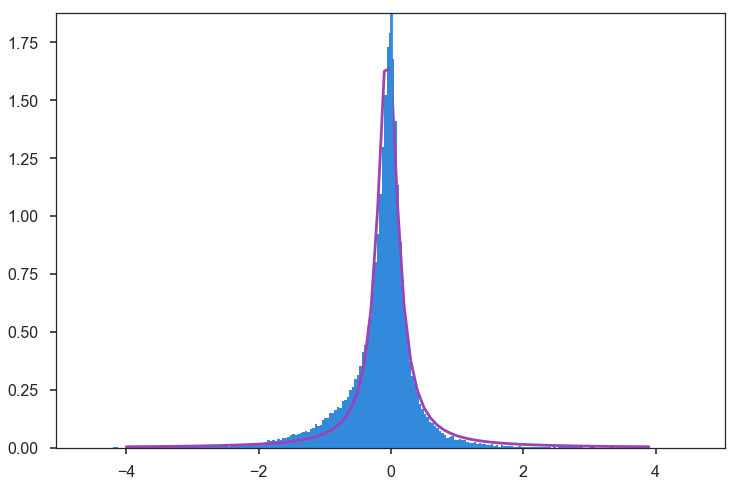

In [21]:
_ = hist(np.log(ratios[good_pts]), bins='scott', normed=True)
pl.plot(np.arange(-4, 4, 0.1), stats.cauchy.pdf(np.arange(-4, 4, 0.1), *cauchy_fit))
pl.axvline(np.log(1))

The scaling factor is below 1, as expected due to the heavier tail at low values.

The scipy method gives no estimate of uncertainties. Adopting a likelihood model with statsmodels provides an estimate of the parameter uncertainties *assuming normality*.

In [22]:
try:
    from statsmodels.base.model import GenericLikelihoodModel
except ImportError:
    raise ImportError("statsmodels must be installed to run this cell.")

class Likelihood(GenericLikelihoodModel):

    # Get the number of parameters from shapes.
    # Add one for scales, since we're assuming loc is frozen.
    # Keeping loc=0 is appropriate for log-normal models.
    nparams = 1 if stats.cauchy.shapes is None else \
        len(stats.cauchy.shapes.split(",")) + 1

    def loglike(self, params):
        if np.isnan(params).any():
            return - np.inf

        loglikes = \
            stats.cauchy.logpdf(self.endog, *params[:-2],
                                scale=params[-1],
                                loc=params[-2])
        if not np.isfinite(loglikes).all():
            return - np.inf
        else:
            return loglikes.sum()

In [23]:
mle_model = Likelihood(np.log(ratios))
fitted_model = mle_model.fit(cauchy_fit, method='nm')
fitted_model.df_model = len(ratios)
fitted_model.df_resid = len(ratios) - 2

Optimization terminated successfully.
         Current function value: 0.826208
         Iterations: 17
         Function evaluations: 31


In [24]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Likelihood Results                              
==============================================================================
Dep. Variable:                      y   Log-Likelihood:            -1.0881e+05
Model:                     Likelihood   AIC:                         4.810e+05
Method:            Maximum Likelihood   BIC:                         1.770e+06
Date:                Mon, 26 Jun 2017                                         
Time:                        13:07:56                                         
No. Observations:              131700                                         
Df Residuals:                  131698                                         
Df Model:                      131700                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
par0          -0.0494      0.001    -66.344      0.000      -0.051      -0.048
par1           0.1891      0.001    256.181      0.000       0.188       0.191
==============================================================================
"""

In [25]:
print("Scale factor: {0}+/-{1}".format(np.exp(fitted_model.params[0]),
                                       np.exp(fitted_model.params[0]) * fitted_model.bse[0]))

Scale factor: 0.951820961403+/-0.000708415845314




Fitting a distribution is a useful method for finding the scale factor since the significance of outliers is diminished.

However, other methods can be used for finding the scaling factor. By fitting a line between the low- and high-resolution points, the slope will be the scale factor. The mean/median of the ratios may also be used. The issue with both of these methods is the presence of outliers. A robust line fitting method, such as [Theil-Sen Regression](https://en.wikipedia.org/wiki/Theil%E2%80%93Sen_estimator), or iteratively rejecting outliers to compute the mean/median of the ratios should be used. 

All three methods are implemented in `uvcombine.scale_factor.find_scale_factor`. Below is a comparison of the methods.

Optimization terminated successfully.
         Current function value: 0.627595
         Iterations: 41
         Function evaluations: 80
Scale factor: 0.952719290319+/-0.000693531102063


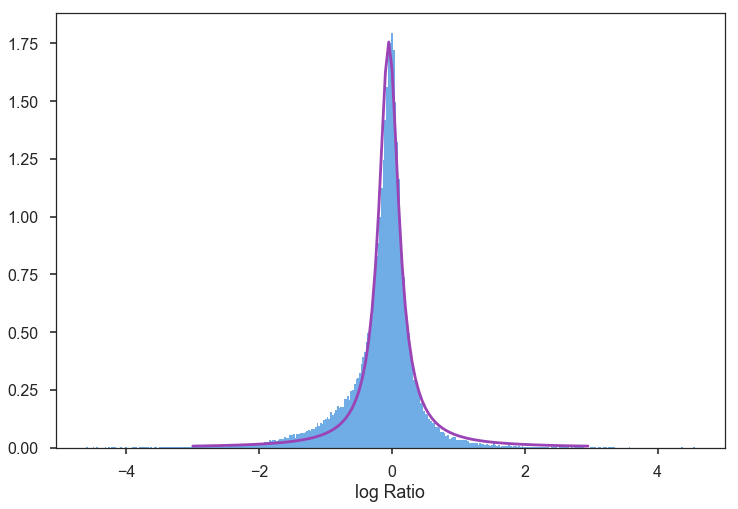

In [26]:
from uvcombine.scale_factor import find_scale_factor

# Distribution
distrib_sf = find_scale_factor(lowres_pts[good_pts], highres_pts[good_pts], method='distrib', verbose=True)
print("Scale factor: {0}+/-{1}".format(distrib_sf[0], distrib_sf[1]))

Scale factor: 0.741717882633 85% CI: 0.724469028939-0.758665010591


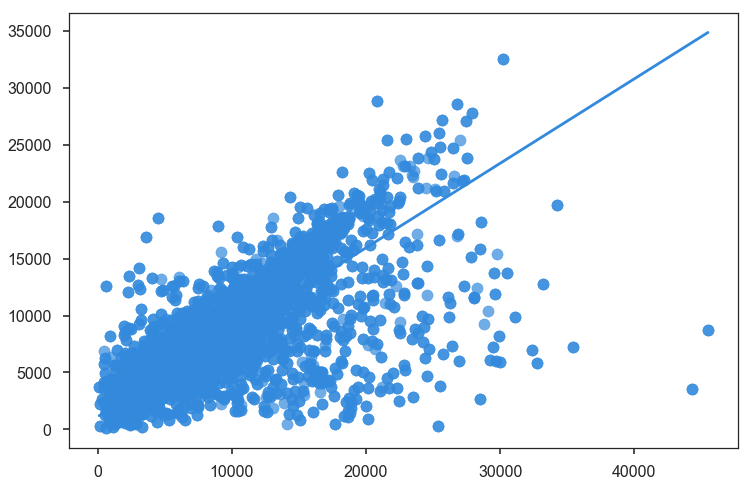

In [30]:
# Linear fit
# The Theil-Sen regression is not memory efficient (it pariwise compares each point). Only use a subset of the points 
linfit_sf = find_scale_factor(lowres_pts[good_pts][:5000], highres_pts[good_pts][:5000], method='linfit', verbose=True)
print("Scale factor: {0} 85% CI: {1}-{2}".format(linfit_sf[0], *linfit_sf[1]))

Scale factor: Mean 0.899020441978 Median 0.929032806945 Std. 0.317260576279


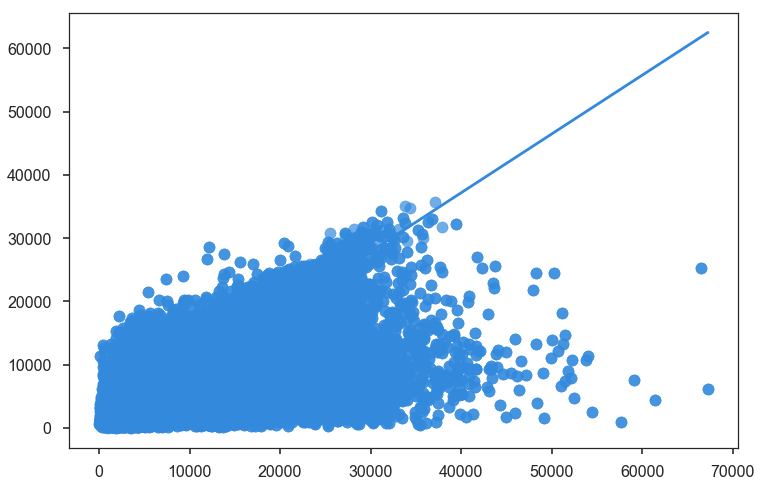

In [31]:
# Sigma-clipped statistics
sigclip_sf = find_scale_factor(lowres_pts[good_pts], highres_pts[good_pts], method='clippedstats', verbose=True)
print("Scale factor: Mean {0} Median {1} Std. {2}".format(sigclip_sf["scale_factor_mean"],
                                                          sigclip_sf["scale_factor_median"],
                                                          sigclip_sf["scale_factor_std"]))

There is significant scatter amongst the three estimates (*note that the Sen-Theil regression only used a sub-set of the points. Too many points will cause a memory error*).

The influence of the outliers is significant in the latter two methods, even using the more robust estimators! The issue is two-fold. First, the asymmetry between the low and high points will cause all of the methods to underestimate the scale factor. This is clear from the distribution fit (and is discussed above). Second, the linear fit and sigma-clipped statistics are still heavily influenced by outliers because the outlier population is a moderate fraction of the data. This shows that, so long as there are enough points available, the Cauchy distribution fit should be used to estimate the scale factor.